In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import binned_statistic_2d
from scipy.signal import hilbert
import cmocean
from matplotlib.colors import Normalize
import gsw
import matplotlib.animation as animation
import requests
from datetime import datetime, timedelta
import matplotlib.dates as mdates

import pandas as pd
from scipy.signal import butter, filtfilt
from io import StringIO
from scipy.ndimage import gaussian_filter
import glob
import os

In [2]:
def bin_var_phase(phase, var, ds, n_bins):
    """
    Bins a variable based on its phase in [0, 2π] using n_bins bins.
    
    Args:
    - phase (xarray.DataArray): The phase values to bin the variable against.
    - var (xarray.DataArray): The variable values to bin.
    - ds (xarray.Dataset): The dataset that contains latitude values.
    - n_bins (int): The number of bins to create.
    
    Returns:
    - phase_bins (numpy.ndarray): The bin edges for the phase.
    - var_binned (numpy.ndarray): The binned data for each latitude and phase bin.
    """
    # Normalize phase between 0 and 2π
    phase_normalized = np.mod(phase, 2 * np.pi) 
    phase_bins = np.linspace(0, 2*np.pi, n_bins + 1)
    latitude = ds['latitude'].values  # Extract latitude from the dataset

    # Initialize an array to store the binned variable data
    var_binned = np.zeros((n_bins, len(latitude)))

    # Loop through each latitude
    for i, lat in enumerate(latitude):
        lat_phase = phase_normalized[:, i]  # Phase values at this latitude
        lat_var = var[:, i]  # Corresponding variable values at this latitude

        # Bin the data: for each phase value, assign a bin index
        bin_indices = np.digitize(lat_phase, phase_bins) - 1  

        # Compute mean for each bin and store it
        for j in range(n_bins):
            var_binned[j, i] = np.nanmean(lat_var[bin_indices == j])  # Avoid NaNs

    return phase_bins, var_binned



# Plot the overall composite using the binned data
def plot_simple_composite_hovmoller(n_bins, composite_ds_2D, latitude, title, plot_params, isotherm_level=None):
    """Creates a Hovmöller plot for the overall composite across all longitudes, with an optional isotherm contour."""
    
    fig, ax = plt.subplots(3, 4, figsize=(14, 8))
    phase_bins = np.linspace(0, 2 * np.pi, n_bins + 1)

    def add_colorbar(c, ax):
        """Helper function to add colorbar."""
        cbar = fig.colorbar(c, ax=ax, orientation="vertical", shrink=0.8)
        cbar.ax.tick_params(labelsize=8)

    for i, (var, params) in enumerate(plot_params.items()):
        row, col = divmod(i, 4)

        # Filled contour plot
        c = ax[row, col].contourf(
            phase_bins[:-1], latitude, composite_ds_2D[var].T, 
            levels=params["levels"], cmap=params["cmap"]
        )
        ax[row, col].set_title(var.replace("_", " "), fontsize=10)
        add_colorbar(c, ax[row, col])

        # Overlay isotherm contour if specified
        if isotherm_level is not None:
            isotherm = ax[row, col].contour(
                phase_bins[:-1], latitude, composite_ds_2D["temp"].T, 
                levels=[isotherm_level], colors="black", linewidths=1.5, linestyles="solid"
            )
            ax[row, col].clabel(isotherm, inline=True, fontsize=8, fmt=f"{isotherm_level}°C")

        # Set x-ticks
        ax[row, col].set_xticks(np.linspace(0, 2 * np.pi, num=5))
        ax[row, col].set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'2$\pi$'])

   # plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()



def plot_large_hovemoller_composite_SD_TAO_SG(composite_ds, phase_txt, n_bins, latitude, SD_df, TAO_df, SG_df, plot_params, glorys_ds):
    """Creates a Hovmöller plot for the overall composite across all longitudes."""
    fig, ax = plt.subplots(3, 4, figsize=(14, 8))
    phase_bins = np.linspace(0, 2*np.pi, n_bins + 1)

    def add_colorbar(c, ax):
        cbar = fig.colorbar(c, ax=ax, orientation="vertical", shrink=0.8)
        cbar.ax.tick_params(labelsize=8)

    for i, (var, params) in enumerate(plot_params.items()):
        row, col = divmod(i, 4)

        # Plot the combined composite
        c = ax[row, col].contourf(
            phase_bins[:-1], latitude, composite_ds[var].T, 
            levels=params["levels"], cmap=params["cmap"]
        )
        ax[row, col].set_title(var.replace("_", " "))
        add_colorbar(c, ax[row, col])

        # SD Fronts: SST front locations with color by front type
        if SD_df is not None:
            for _, front_row in SD_df.iterrows():            
                ax[row, col].scatter(front_row['phase'], front_row['lat'], color='black')

            fronts_df_strong = SD_df[SD_df['temp_diff'] >= 1]
            for _, front_row in fronts_df_strong.iterrows():            
                ax[row, col].scatter(front_row['phase'], front_row['lat'], color='red')

        # TAO Fronts: SST front locations with color by front type (classification)
        if TAO_df is not None:
            for _, front_row in TAO_df.iterrows():
                front_color = "red" if front_row['front_type'].lower() == "warm front" else "blue"
                ax[row, col].scatter(front_row['phase'], front_row['lat'], color='gray')

        # Seaglider Fronts: SST front locations with color by front type (classification)
        if SG_df is not None:
            for _, front_row in SG_df.iterrows():
                ax[row, col].scatter(front_row['phase'], front_row['lat'], color='hotpink')

        # Highlight key points with orange horizontal markers
        highlight_points = [(6.2, 0), (6.2, 2), (6.2, 5), (6.26, 8), (6.26, 9)]
        for x, y in highlight_points:
            ax[row, col].scatter(x, y, color="orange", marker="_", s=100, linewidth=5)

        ax[row, col].set_xlim(0, 2*np.pi)
        ax[row, col].set_xticks(np.linspace(0, 2*np.pi, num=5))
        ax[row, col].set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'2$\pi$'])

    # Extract metadata from GLORYS dataset
    time_range = f"{glorys_ds['time'].min().dt.strftime('%b %d, %Y').values} to {glorys_ds['time'].max().dt.strftime('%b %d, %Y').values}"
    lon_range = f"{glorys_ds['longitude'].min().values:.2f}° to {glorys_ds['longitude'].max().values:.2f}°"
    lat_range = f"{glorys_ds['latitude'].min().values:.2f}° to {glorys_ds['latitude'].max().values:.2f}°"
    depth = f"{glorys_ds['depth'].values.round()}" if "depth" in glorys_ds else "N/A"

    # Set the title with GLORYS metadata
    plt.suptitle(f"Time: {time_range} | Lon: {lon_range} | Lat: {lat_range} | Depth: {depth}")
    plt.tight_layout()
    plt.show()


def create_composite(phase_txt, plot_params, phase_ds, glorys_ds, lon_range, n_bins,lat_0):
    # Initialize a dictionary to store composites for each variable
    composite_data = {var: [] for var in plot_params.keys()}
    phase_ds_lon_list = []  # List to accumulate phase_ds_lon for each longitude
    
    # Loop over all longitudes and aggregate data
    for lon_0 in lon_range:
        phase_ds_lon = phase_ds.sel(longitude=lon_0, method='nearest')
        glorys_ds_lon = glorys_ds.sel(longitude=lon_0, method='nearest')

        # Define latitude reference point (use the middle latitude, or another logic)
        latitude = phase_ds_lon['latitude'].values
        
        # Extract phase and repeat across latitude
        phase_lon = phase_ds_lon[phase_txt].sel(latitude=lat_0, method='nearest')
        phase_lon_values = phase_lon.values[:, np.newaxis]  # Ensure 2D
        phase_lon_repeated = np.repeat(phase_lon_values, len(latitude), axis=1)

        # Add repeated phase to dataset
        phase_txt_repeated = phase_txt + '_repeated'
        phase_ds_lon[phase_txt_repeated] = (('time', 'latitude'), phase_lon_repeated)

        # Append phase_ds_lon to the list
        phase_ds_lon_list.append(phase_ds_lon)

        # Bin data for each variable
        for var in plot_params.keys():
            if var == "temp_gradient":
                _, binned_data = bin_var_phase(phase_ds_lon[phase_txt_repeated],
                                               np.abs(glorys_ds_lon['temp_gradient']),
                                               glorys_ds_lon, n_bins)
            else:
                _, binned_data = bin_var_phase(phase_ds_lon[phase_txt_repeated],
                                               glorys_ds_lon[var], glorys_ds_lon, n_bins)

            # Append binned data
            composite_data[var].append(binned_data)

    # Stack the phase_ds_lon list along the longitude dimension
    phase_ds_lon_stacked = xr.concat(phase_ds_lon_list, dim="longitude")

    # Convert to an xarray Dataset (After processing all longitudes)
    composite_ds = xr.Dataset(
        {var: (["longitude", "phase_bins", "latitude"], np.array(composite_data[var])) for var in composite_data.keys()},
        coords={
            "longitude": lon_range,
            "phase_bins": np.linspace(-np.pi, np.pi, n_bins),  # Define phase bins
            "latitude": latitude
        }
    )

    # Return the composite dataset and the stacked phase_ds_lon
    return composite_ds, phase_ds_lon_stacked

def assign_phase(row, phase_ds_lon, lon_range):
    # Convert valid range values to Pandas Timestamps for proper comparison
    valid_time_range = (
        pd.Timestamp(phase_ds_lon["time"].min().item()), 
        pd.Timestamp(phase_ds_lon["time"].max().item())
    )
    valid_lat_range = (
        phase_ds_lon["latitude"].min().item(), 
        phase_ds_lon["latitude"].max().item()
    )
    
    valid_lon_range = (
        phase_ds_lon["longitude"].min().item(), 
        phase_ds_lon["longitude"].max().item()
    )

    """Interpolates phase value for each front row, ensuring it's within limits."""
    if not (valid_time_range[0] <= row["time"] <= valid_time_range[1]):
        return np.nan  

    if not (valid_lat_range[0] <= row["lat"] <= valid_lat_range[1]):
        return np.nan 

    if not (valid_lon_range[0] <= row["lon"] <= valid_lon_range[1]):
        return np.nan  

    phase_interp = phase_ds_lon[phase_txt].sel(
        longitude=row["lon"],time=row["time"], latitude=row["lat"], method="nearest"
    )
    
    return phase_interp.item() if not np.isnan(phase_interp) else np.nan



def plot_large_hovemoller_lon_specific_SD(composite_ds, phase_txt, n_bins, latitude, fronts_df, lon,glorys_ds):
    """Creates a Hovmöller plot for the overall composite across all longitudes."""
    fig, ax = plt.subplots(3, 4, figsize=(14, 8))
    phase_bins = np.linspace(0, 2*np.pi, n_bins + 1)

    def add_colorbar(c, ax):
        cbar = fig.colorbar(c, ax=ax, orientation="vertical", shrink=0.8)
        cbar.ax.tick_params(labelsize=8)

    for i, (var, params) in enumerate(plot_params.items()):
        row, col = divmod(i, 4)

        # Plot the combined composite
        c = ax[row, col].contourf(
            phase_bins[:-1], latitude, composite_ds[var].T, 
            levels=params["levels"], cmap=params["cmap"]
        )
        ax[row, col].set_title(f"{var.replace('_', ' ')}\nLongitude: {lon:.2f}")
        add_colorbar(c, ax[row, col])

        # Scatter plot: SST front locations with color by front type
        if isinstance(fronts_df, pd.DataFrame):  # Check if it's a DataFrame
            for _, front_row in fronts_df.iterrows():
                ax[row, col].scatter(
                    front_row['phase'], 
                    front_row['lat'], 
                    color='black'
                )

        # For strong fronts
        fronts_df_strong = fronts_df[fronts_df['temp_diff'] >= 1]
        if isinstance(fronts_df_strong, pd.DataFrame):  # Ensure it's a DataFrame
            for _, front_row in fronts_df_strong.iterrows():
                ax[row, col].scatter(
                    front_row['phase'], 
                    front_row['lat'], 
                    color='red'
                )

        ax[row, col].set_xticks(np.linspace(0, 2*np.pi, num=5))
        ax[row, col].set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'2$\pi$'])

    # Extract metadata from GLORYS dataset
    time_range = f"{glorys_ds['time'].min().dt.strftime('%b %d, %Y').values} to {glorys_ds['time'].max().dt.strftime('%b %d, %Y').values}"
    lon_range = f"{glorys_ds['longitude'].min().values:.2f}° to {glorys_ds['longitude'].max().values:.2f}°"
    lat_range = f"{glorys_ds['latitude'].min().values:.2f}° to {glorys_ds['latitude'].max().values:.2f}°"
    depth = f"{glorys_ds['depth'].values.round()}" if "depth" in glorys_ds else "N/A"

    # Set the title with GLORYS metadata
    plt.suptitle(f"{phase_txt.replace('_', ' ')}\nTime: {time_range} | Lon: {lon_range} | Lat: {lat_range} | Depth: {depth}")

    
   # plt.suptitle(f"{phase_txt.replace('_', ' ')} at Longitude: {lon:.2f}")
    plt.tight_layout()
    plt.show()



def plot_composite_hovmoller_one_var(n_bins, composite_ds, latitude, plot_params,iso_temp,glorys_ds):
    """Creates a single figure with multiple subplots showing Hovmöller diagrams at different longitudes, 
    including a 25.6°C isotherm contour."""
    
    longitudes = composite_ds["longitude"].values  # Get all longitudes
    n_lons = len(longitudes)  # Number of subplots needed
    
    n_cols = 4  # Set a fixed number of columns
    n_rows = int(np.ceil(n_lons / n_cols))  # Dynamically determine rows
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows), sharey=True)  # Shared y-axis
    axes = np.atleast_2d(axes)  # Ensure 2D array for consistency
    
    phase_bins = np.linspace(0, 2 * np.pi, n_bins + 1)

    def add_colorbar(c, ax):
        """Helper function to add colorbar."""
        cbar = fig.colorbar(c, ax=ax, orientation="vertical", shrink=0.8)
        cbar.ax.tick_params(labelsize=8)

    for i, lon in enumerate(longitudes):
        row, col = divmod(i, n_cols)

        composite_ds_2D = composite_ds.sel(longitude=lon)  # Extract 2D slice
        
        for var, params in plot_params.items():  # Loop through variables (only "temp" in this case)
            # Filled contour plot
            c = axes[row, col].contourf(
                phase_bins[:-1], latitude, composite_ds_2D[var].T, 
                levels=params["levels"], cmap=params["cmap"]
            )
            
            # Add isotherm contour line at 25.6°C
            isotherm = axes[row, col].contour(
                phase_bins[:-1], latitude, composite_ds_2D[var].T, 
                levels=[iso_temp], colors="black", linewidths=1.5, linestyles="solid"
            )
            axes[row, col].clabel(isotherm, inline=True, fontsize=8, fmt="25.6°C")  # Label the contour line

            axes[row, col].set_title(f"{lon:.2f}°", fontsize=10)
            add_colorbar(c, axes[row, col])

            axes[row, col].set_xticks(np.linspace(0, 2*np.pi, num=5))
            axes[row, col].set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'2$\pi$'])


    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        row, col = divmod(j, n_cols)
        fig.delaxes(axes[row, col])
        
    # Extract metadata from GLORYS dataset
    time_range = f"{glorys_ds['time'].min().dt.strftime('%b %d, %Y').values} to {glorys_ds['time'].max().dt.strftime('%b %d, %Y').values}"
    lon_range = f"{glorys_ds['longitude'].min().values:.2f}° to {glorys_ds['longitude'].max().values:.2f}°"
    lat_range = f"{glorys_ds['latitude'].min().values:.2f}° to {glorys_ds['latitude'].max().values:.2f}°"
    depth = f"{glorys_ds['depth'].values.round()}" if "depth" in glorys_ds else "N/A"

    # Set the title with GLORYS metadata
    plt.suptitle(f"{phase_txt.replace('_', ' ')}\nTime: {time_range} | Lon: {lon_range} | Lat: {lat_range} | Depth: {depth}")
   # plt.suptitle("Hovmöller Diagrams at Different Longitudes (w/ 25.6°C Isotherm)", fontsize=12)
    plt.tight_layout()
    plt.show()

In [4]:
plot_params = {
    "temp": {"cmap": cmocean.cm.thermal, "levels": np.linspace(22, 30, 50)},
    "temp_gradient": {"cmap": cmocean.cm.dense, "levels": np.linspace(0, 0.2, 50)},
    "sal": {"cmap": cmocean.cm.haline, "levels": np.linspace(33, 35.2, 50)},
    "sal_anomaly": {"cmap": cmocean.cm.balance, "levels": np.linspace(-0.3, 0.3, 50)},
    "relative_vorticity_normalized": {"cmap": cmocean.cm.curl, "levels": np.linspace(-0.5e6, 0.5e6, 50)},
    "shear_rate_normalized": {"cmap": cmocean.cm.curl, "levels": np.linspace(-0.5e6, 0.5e6, 50)},
    "convergence": {"cmap": cmocean.cm.curl, "levels": np.linspace(-0.5, 0.5, 50)},
    "T_b_hor": {"cmap": cmocean.cm.balance, "levels": np.linspace(-1e-19, 1e-19, 50)},
    "T_v_hor": {"cmap": cmocean.cm.balance, "levels": np.linspace(-2e-15, 2e-15, 50)},
    "HCL": {"cmap": cmocean.cm.balance, "levels": np.linspace(-2e-5, 2e-5, 50)},
    "uo": {"cmap": cmocean.cm.delta, "levels": np.linspace(-1.5, 1.5, 50)},
    "vo": {"cmap": cmocean.cm.delta, "levels": np.linspace(-1, 1, 50)}
}



In [10]:
# Inputs
lon_0 = -140
lat_0 = 2
n_bins = 30
lon_range = np.arange(-170, -110, 1) #rightnow constrained by the glorys data
phase_txt = 'phase_anomaly_detrended'

latitude = glorys_ds['latitude']

## Read in composite datasets (from tiw-phase-composite-wfronts)

In [24]:
composite_ds = xr.open_dataset('/Volumes/external/TIW/netCDF/composite-2017-08-01-to-2018-02-28.nc')
composite_ds = composite_ds.sel(longitude = slice(-150,-111))
phase_ds_lon = xr.open_dataset('/Volumes/external/TIW/netCDF/phase_ds_lon-2017-08-01-to-2018-02-28.nc')
phase_ds_lon = phase_ds_lon.sel(longitude = slice(-150,-111))

In [33]:
phase_ds_lon

<xarray.Dataset> Size: 66MB
Dimensions:                           (longitude: 40, time: 212, latitude: 121)
Coordinates:
  * time                              (time) datetime64[ns] 2kB 2017-08-01 .....
  * latitude                          (latitude) float32 484B 0.0 ... 10.0
  * longitude                         (longitude) float32 160B -150.0 ... -111.0
Data variables:
    temp_sfc                          (longitude, time, latitude) float64 8MB ...
    temp_anomaly_sfc                  (longitude, time, latitude) float64 8MB ...
    temp_butter_sfc                   (longitude, time, latitude) float64 8MB ...
    temp_anomaly_detrended_sfc        (longitude, time, latitude) float64 8MB ...
    phase_butter                      (longitude, time, latitude) float64 8MB ...
    phase_anomaly                     (longitude, time, latitude) float64 8MB ...
    phase_anomaly_detrended           (longitude, time, latitude) float64 8MB ...
    phase_anomaly_detrended_repeated  (longitude, time, latitude) float64 8MB ...

In [65]:
sd_1005 = xr.open_dataset('/Volumes/external/TIW/data/saildrone/2017/1min/TPOS-2017_SD1005_1min.nc')
sd_1006 = xr.open_dataset('/Volumes/external/TIW/data/saildrone/2017/1min/TPOS-2017_SD1006_1min.nc')

In [66]:
sd_1005

<xarray.Dataset> Size: 195MB
Dimensions:                          (row: 368640)
Dimensions without coordinates: row
Data variables: (12/66)
    trajectory                       (row) object 3MB ...
    time                             (row) datetime64[ns] 3MB ...
    latitude                         (row) float64 3MB ...
    longitude                        (row) float64 3MB ...
    TEMP_O2_STDDEV                   (row) float64 3MB ...
    SW_UNMASKED_IRRAD_CENTER_MEAN    (row) float64 3MB ...
    ...                               ...
    COG                              (row) float64 3MB ...
    WING_ANGLE                       (row) float64 3MB ...
    PITCH                            (row) float64 3MB ...
    wind_speed                       (row) float64 3MB ...
    wind_dir                         (row) float64 3MB ...
    distance_1005_1006               (row) float64 3MB ...
Attributes: (12/66)
    acknowledgement:                     If you use these data in publication...
    area:                                California to 0N 125W and back
    cdm_data_type:                       Trajectory
    cdm_trajectory_variables:            trajectory
    citation:                            Please cite Zhang et al. (2019) when...
    contributor_email:                   Nathan.anderson@noaa.gov; dongxiao.z...
    ...                                  ...
    creator_institution:                 Saildrone Inc. and PMEL
    publisher_name:                      NOAA PMEL
    publisher_url:                       pmel.noaa.gov
    QC_manual:                           No QC performed
    time_in:                             seconds
    source:                              NOAA Saildrone Missions

In [69]:
phase_interp = phase_ds_lon['phase_anomaly_detrended_repeated'].interp(
    latitude=sd_1005['latitude'],
    longitude=sd_1005['longitude'],
    time=sd_1005['time'],
    method='nearest'
)

phase_interp_clean = phase_interp.reset_coords(names=['latitude', 'longitude', 'time'], drop=True)
sd_1005['phase'] = phase_interp_clean
sd_1005['phase'] = (sd_1005['phase'] + 2*np.pi) % (2*np.pi)

In [70]:
phase_interp = phase_ds_lon['phase_anomaly_detrended_repeated'].interp(
    latitude=sd_1006['latitude'],
    longitude=sd_1006['longitude'],
    time=sd_1006['time'],
    method='nearest'
)

phase_interp_clean = phase_interp.reset_coords(names=['latitude', 'longitude', 'time'], drop=True)
sd_1006['phase'] = phase_interp_clean
sd_1006['phase'] = (sd_1006['phase'] + 2*np.pi) % (2*np.pi)

In [74]:
sd_1006

<xarray.Dataset> Size: 198MB
Dimensions:                          (row: 368640)
Dimensions without coordinates: row
Data variables: (12/67)
    trajectory                       (row) object 3MB ...
    time                             (row) datetime64[ns] 3MB 2017-09-02 ... ...
    latitude                         (row) float64 3MB 37.67 37.67 ... nan nan
    longitude                        (row) float64 3MB -122.7 -122.7 ... nan nan
    TEMP_O2_STDDEV                   (row) float64 3MB ...
    SW_UNMASKED_IRRAD_CENTER_MEAN    (row) float64 3MB ...
    ...                               ...
    WING_ANGLE                       (row) float64 3MB ...
    PITCH                            (row) float64 3MB ...
    wind_speed                       (row) float64 3MB ...
    wind_dir                         (row) float64 3MB ...
    distance_1005_1006               (row) float64 3MB ...
    phase                            (row) float64 3MB nan nan nan ... nan nan
Attributes: (12/66)
    acknowledgement:                     If you use these data in publication...
    area:                                California to 0N 125W and back
    cdm_data_type:                       Trajectory
    cdm_trajectory_variables:            trajectory
    citation:                            Please cite Zhang et al. (2019) when...
    contributor_email:                   Nathan.anderson@noaa.gov; dongxiao.z...
    ...                                  ...
    creator_institution:                 Saildrone Inc. and PMEL
    publisher_name:                      NOAA PMEL
    publisher_url:                       pmel.noaa.gov
    QC_manual:                           No QC performed
    time_in:                             seconds
    source:                              NOAA Saildrone Missions

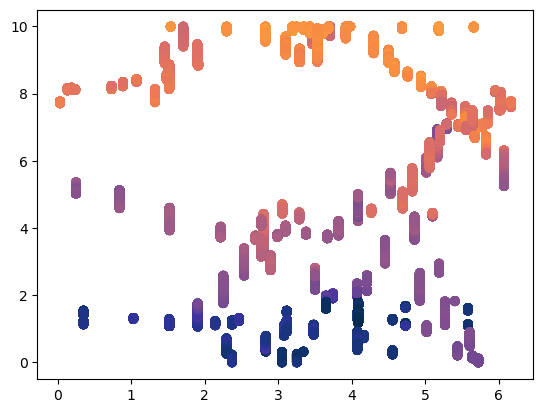

In [77]:
plt.scatter(sd_1005['phase'],sd_1005['latitude'],c=sd_1005['TEMP_CTD_MEAN'],cmap=cmocean.cm.thermal,vmin=22,vmax=30)
plt.scatter(sd_1006['phase'],sd_1006['latitude'],c=sd_1006['TEMP_CTD_MEAN'],cmap=cmocean.cm.thermal,vmin=22,vmax=30)

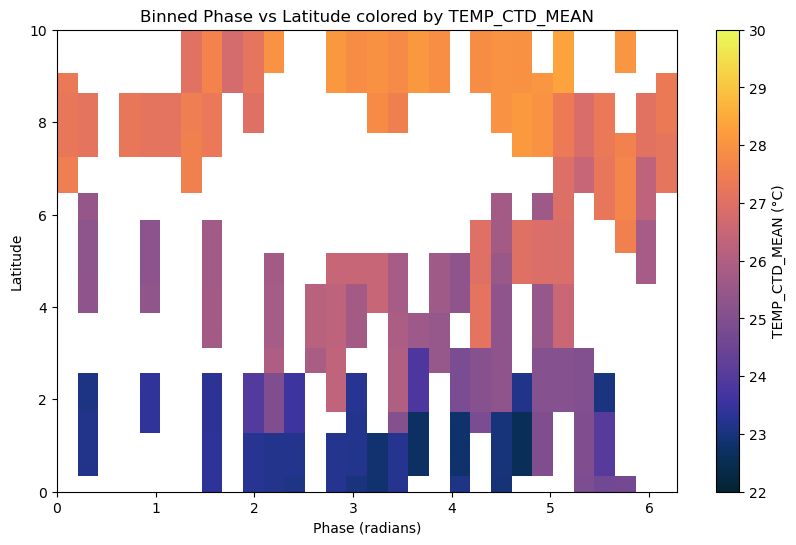

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean

def binned_2d_plot(ax, ds, var , label,cmap,vmin,vmax):
    # Set up bins
    phase_bins = np.linspace(0, 2*np.pi, 31)    # 30 bins in phase
    lat_bins = np.linspace(ds['latitude'].min(), ds['latitude'].max(), 31)  # 30 bins in latitude

    # 2D histogram: average TEMP_CTD_MEAN in (phase, lat) bins
    H_temp = np.full((len(lat_bins)-1, len(phase_bins)-1), np.nan)

    # Digitize to find bin indices
    phase_idx = np.digitize(ds['phase'], phase_bins) - 1
    lat_idx = np.digitize(ds['latitude'], lat_bins) - 1

    for i in range(len(phase_bins)-1):
        for j in range(len(lat_bins)-1):
            in_bin = (phase_idx == i) & (lat_idx == j)
            if np.any(in_bin):
                H_temp[j,i] = ds[var][in_bin].mean()

    # Plot as colored rectangles
    pcm = ax.pcolormesh(phase_bins, lat_bins, H_temp, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')

    return pcm

fig, ax = plt.subplots(figsize=(10,6))

# Plot both datasets
pcm1 = binned_2d_plot(ax, sd_1005, var='TEMP_CTD_MEAN',label='SD1005', cmap=cmocean.cm.thermal, vmin=22, vmax=30)
pcm2 = binned_2d_plot(ax, sd_1006,var='TEMP_CTD_MEAN', label='SD1006', cmap=cmocean.cm.thermal, vmin=22, vmax=30)  # overlays second one

# Colorbar
cbar = plt.colorbar(pcm1, ax=ax, label='TEMP_CTD_MEAN (°C)')
ax.set_xlabel('Phase (radians)')
ax.set_ylabel('Latitude')
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(0, 10)
ax.set_title('Binned Phase vs Latitude colored by TEMP_CTD_MEAN')
plt.show()


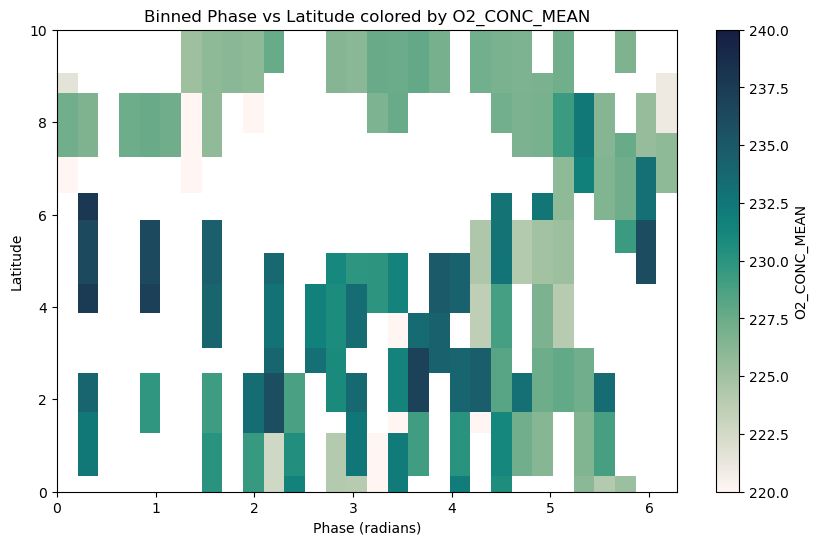

In [102]:
fig, ax = plt.subplots(figsize=(10,6))
# Plot both datasets
pcm1 = binned_2d_plot(ax, sd_1005, var='O2_CONC_MEAN',label='SD1005', cmap=cmocean.cm.tempo, vmin=220, vmax=240)
pcm2 = binned_2d_plot(ax, sd_1006,var='O2_CONC_MEAN', label='SD1006', cmap=cmocean.cm.tempo, vmin=220, vmax=240)  # overlays second one

# Colorbar
cbar = plt.colorbar(pcm1, ax=ax, label='O2_CONC_MEAN')
ax.set_xlabel('Phase (radians)')
ax.set_ylabel('Latitude')
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(0, 10)
ax.set_title('Binned Phase vs Latitude colored by O2_CONC_MEAN')
plt.show()


In [103]:
sd_1005

<xarray.Dataset> Size: 198MB
Dimensions:                          (row: 368640)
Dimensions without coordinates: row
Data variables: (12/67)
    trajectory                       (row) object 3MB ...
    time                             (row) datetime64[ns] 3MB 2017-09-02 ... ...
    latitude                         (row) float64 3MB 37.66 37.66 ... nan nan
    longitude                        (row) float64 3MB -122.7 -122.7 ... nan nan
    TEMP_O2_STDDEV                   (row) float64 3MB ...
    SW_UNMASKED_IRRAD_CENTER_MEAN    (row) float64 3MB ...
    ...                               ...
    WING_ANGLE                       (row) float64 3MB ...
    PITCH                            (row) float64 3MB ...
    wind_speed                       (row) float64 3MB ...
    wind_dir                         (row) float64 3MB ...
    distance_1005_1006               (row) float64 3MB ...
    phase                            (row) float64 3MB nan nan nan ... nan nan
Attributes: (12/66)
    acknowledgement:                     If you use these data in publication...
    area:                                California to 0N 125W and back
    cdm_data_type:                       Trajectory
    cdm_trajectory_variables:            trajectory
    citation:                            Please cite Zhang et al. (2019) when...
    contributor_email:                   Nathan.anderson@noaa.gov; dongxiao.z...
    ...                                  ...
    creator_institution:                 Saildrone Inc. and PMEL
    publisher_name:                      NOAA PMEL
    publisher_url:                       pmel.noaa.gov
    QC_manual:                           No QC performed
    time_in:                             seconds
    source:                              NOAA Saildrone Missions

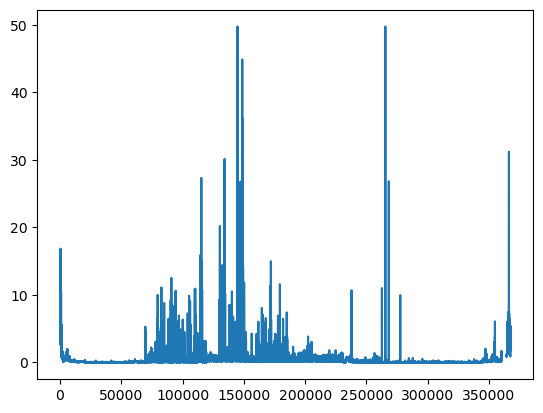

In [117]:
plt.plot(sd_1006[var])

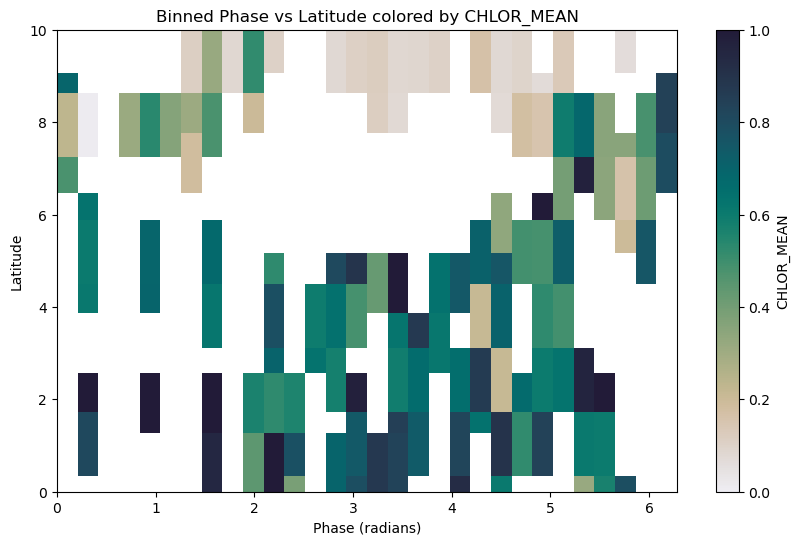

In [121]:
var='CHLOR_MEAN'

fig, ax = plt.subplots(figsize=(10,6))
# Plot both datasets
pcm1 = binned_2d_plot(ax, sd_1005, var,label='SD1005', cmap=cmocean.cm.rain, vmin=0, vmax=1)
pcm2 = binned_2d_plot(ax, sd_1006,var, label='SD1006', cmap=cmocean.cm.rain, vmin=0, vmax=1)  # overlays second one

# Colorbar
cbar = plt.colorbar(pcm1, ax=ax, label=var)
ax.set_xlabel('Phase (radians)')
ax.set_ylabel('Latitude')
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(0, 10)
ax.set_title(f'Binned Phase vs Latitude colored by {var}')
plt.show()

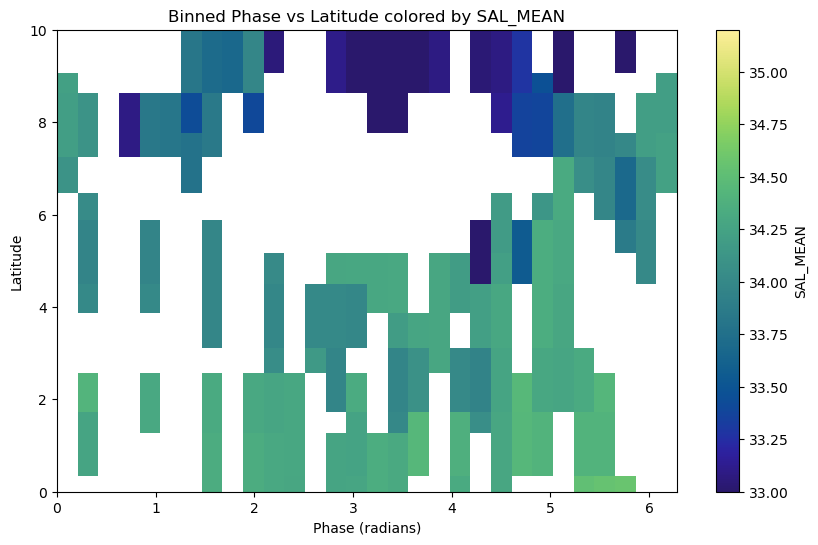

In [112]:
fig, ax = plt.subplots(figsize=(10,6))
# Plot both datasets
pcm1 = binned_2d_plot(ax, sd_1005, var='SAL_MEAN',label='SD1005', cmap=cmocean.cm.haline, vmin=33, vmax=35.2)
pcm2 = binned_2d_plot(ax, sd_1006,var='SAL_MEAN', label='SD1006', cmap=cmocean.cm.haline, vmin=33, vmax=35.2)  # overlays second one

# Colorbar
cbar = plt.colorbar(pcm1, ax=ax, label='SAL_MEAN')
ax.set_xlabel('Phase (radians)')
ax.set_ylabel('Latitude')
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(0, 10)
ax.set_title('Binned Phase vs Latitude colored by SAL_MEAN')
plt.show()


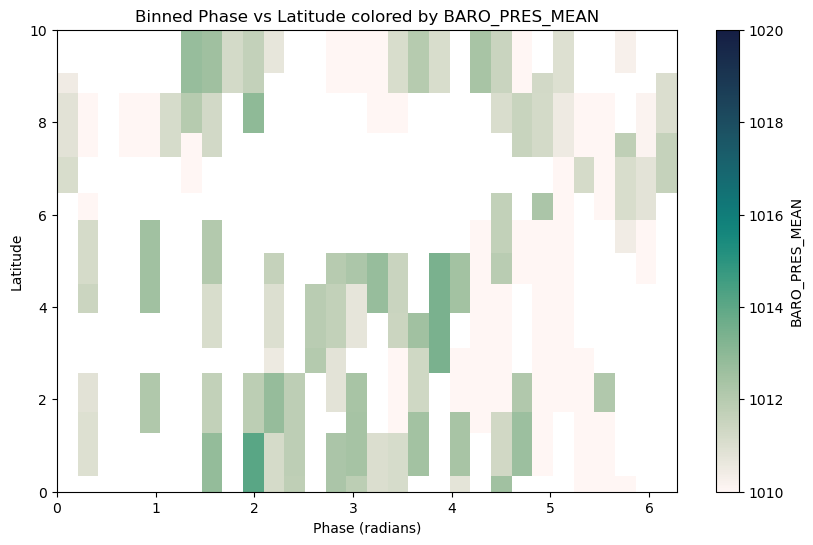

In [107]:
fig, ax = plt.subplots(figsize=(10,6))
# Plot both datasets
pcm1 = binned_2d_plot(ax, sd_1005, var='BARO_PRES_MEAN',label='SD1005', cmap=cmocean.cm.tempo, vmin=1010, vmax=1020)
pcm2 = binned_2d_plot(ax, sd_1006,var='BARO_PRES_MEAN', label='SD1006', cmap=cmocean.cm.tempo, vmin=1010, vmax=1020)  # overlays second one

# Colorbar
cbar = plt.colorbar(pcm1, ax=ax, label='BARO_PRES_MEAN')
ax.set_xlabel('Phase (radians)')
ax.set_ylabel('Latitude')
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(0, 10)
ax.set_title('Binned Phase vs Latitude colored by BARO_PRES_MEAN')
plt.show()


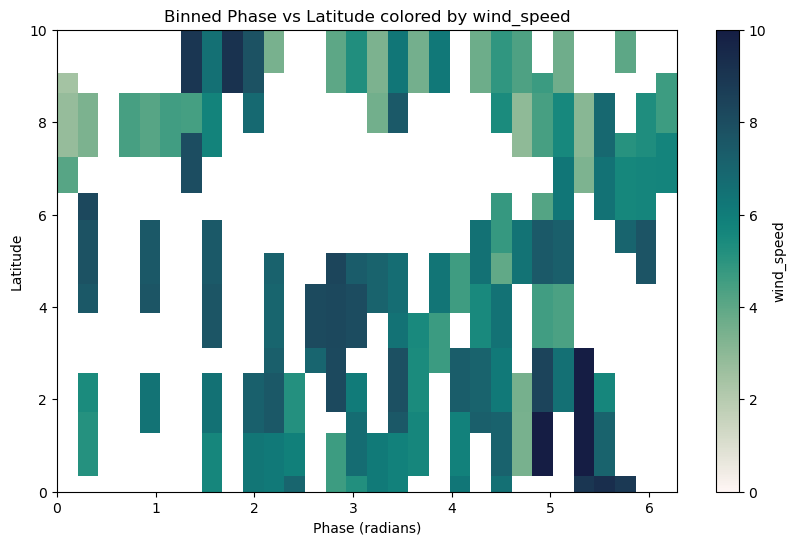

In [109]:
fig, ax = plt.subplots(figsize=(10,6))
# Plot both datasets
pcm1 = binned_2d_plot(ax, sd_1005, var='wind_speed',label='SD1005', cmap=cmocean.cm.tempo, vmin=0, vmax=10)
pcm2 = binned_2d_plot(ax, sd_1006,var='wind_speed', label='SD1006', cmap=cmocean.cm.tempo, vmin=0, vmax=10)  # overlays second one

# Colorbar
cbar = plt.colorbar(pcm1, ax=ax, label='wind_speed')
ax.set_xlabel('Phase (radians)')
ax.set_ylabel('Latitude')
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(0, 10)
ax.set_title('Binned Phase vs Latitude colored by wind_speed')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_isotherm_hovmoller(n_bins, composite_ds, latitude, iso_temp):
    """Creates a single plot showing the 25.6°C isotherm contour at multiple longitudes."""
    
    fig, ax = plt.subplots(figsize=(10, 8))  # Single plot
    phase_bins = np.linspace(0, 2 * np.pi, n_bins + 1)
    
    longitudes = composite_ds["longitude"].values
    colors = plt.cm.hsv(np.linspace(0, 1, len(longitudes)))  # Generate distinct colors
    
    legend_handles = []  # Store legend elements

    for lon, color in zip(longitudes, colors):
        composite_ds_2D = composite_ds.sel(longitude=lon)  # Extract 2D slice
        
        # Extract the isotherm contour at `iso_temp`
        isotherm = ax.contour(
            phase_bins[:-1], latitude, composite_ds_2D["temp"].T, 
            levels=[iso_temp], colors=[color], linewidths=1.5, linestyles="solid"
        )
        
        # Add legend entry manually
        legend_handles.append(Line2D([0], [0], color=color, lw=2, label=f"{lon:.2f}°"))

    # Compute and plot mean isotherm across longitudes
    composite_ds_2D_mean = composite_ds.mean(dim='longitude')  
    isotherm_mean = ax.contour(
        phase_bins[:-1], latitude, composite_ds_2D_mean["temp"].T, 
        levels=[iso_temp], colors='black', linewidths=3, linestyles="solid"
    )
    
    # Add the average line to legend
    legend_handles.append(Line2D([0], [0], color='black', lw=3, label='Mean'))

    # Formatting
    ax.set_xticks(np.linspace(0, 2*np.pi, num=5))
    ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'2$\pi$'])
    ax.set_xlabel("Phase")
    ax.set_ylabel("Latitude")
    ax.set_title(f"Hovmöller Diagram of {iso_temp}°C Isotherm Across Longitudes")

    ax.legend(handles=legend_handles, title="Longitude", loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=8)

    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
    
# composite 2d with isotherm
plot_simple_composite_hovmoller(
    n_bins, 
    composite_ds.mean(dim='longitude'), 
    latitude, 
    title=f"Hovmöller Diagram", 
    plot_params=plot_params, 
    isotherm_level=25.5 
)

### Compare hovemoller plots across longitudes within range

#### SST

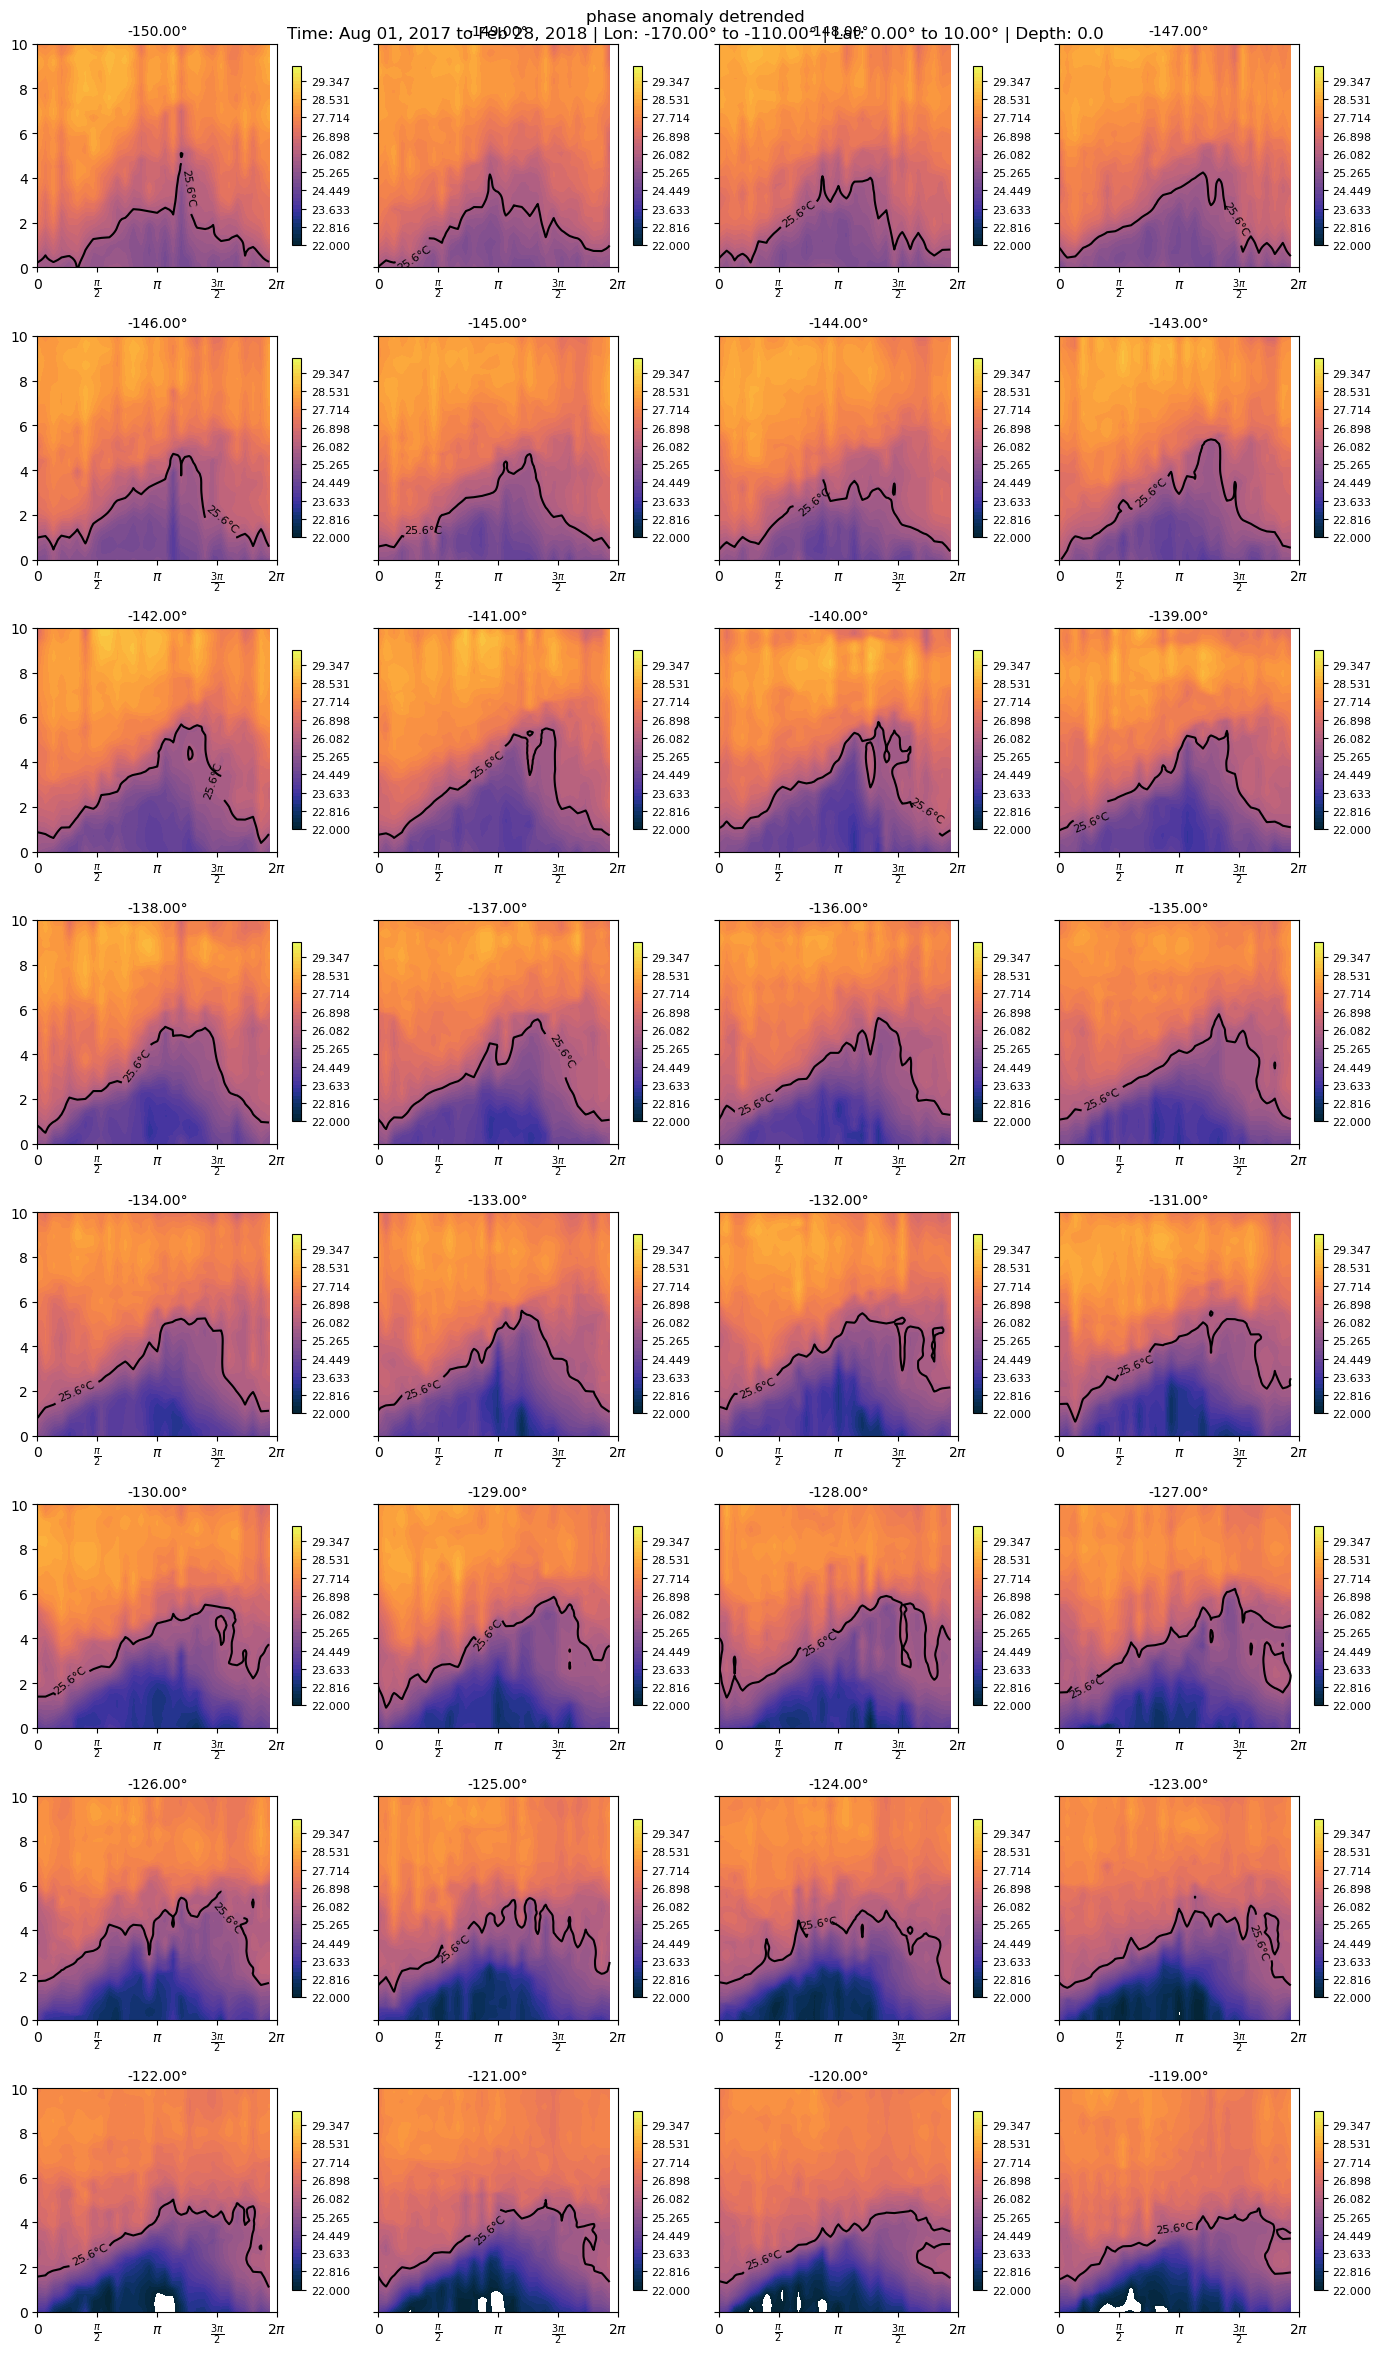

In [23]:
# Define plot parameters
plot_params_one_var = {"temp": {"cmap": cmocean.cm.thermal, "levels": np.linspace(22, 30, 50)}}

# Call function to plot all longitudes in one figure
plot_composite_hovmoller_one_var(n_bins, composite_ds, latitude, plot_params_one_var,iso_temp=25.8,glorys_ds=glorys_ds)


/Users/katiekohlman/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


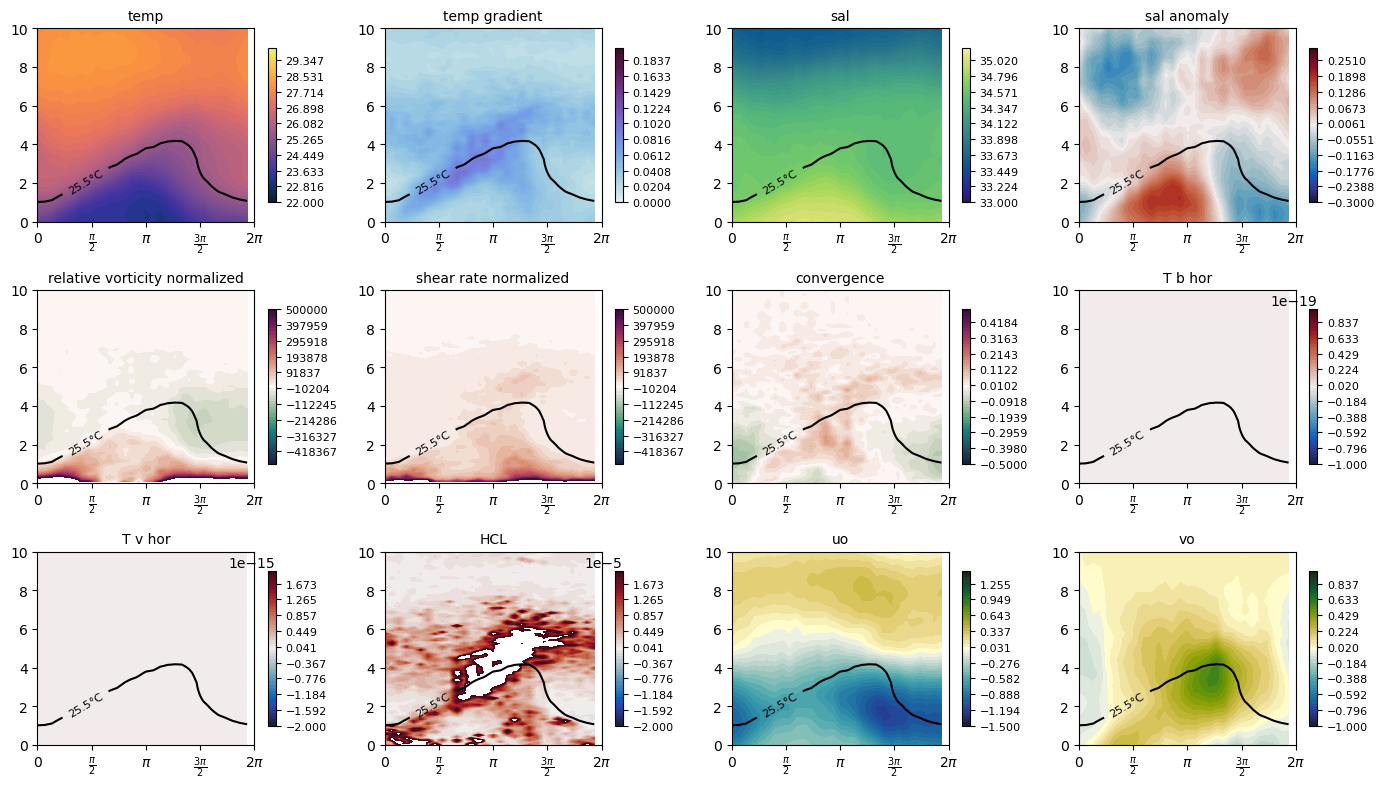

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_isotherm_hovmoller(n_bins, composite_ds, latitude, iso_temp):
    """Creates a single plot showing the 25.6°C isotherm contour at multiple longitudes."""
    
    fig, ax = plt.subplots(figsize=(10, 8))  # Single plot
    phase_bins = np.linspace(0, 2 * np.pi, n_bins + 1)
    
    longitudes = composite_ds["longitude"].values
    colors = plt.cm.hsv(np.linspace(0, 1, len(longitudes)))  # Generate distinct colors
    
    legend_handles = []  # Store legend elements

    for lon, color in zip(longitudes, colors):
        composite_ds_2D = composite_ds.sel(longitude=lon)  # Extract 2D slice
        
        # Extract the isotherm contour at `iso_temp`
        isotherm = ax.contour(
            phase_bins[:-1], latitude, composite_ds_2D["temp"].T, 
            levels=[iso_temp], colors=[color], linewidths=1.5, linestyles="solid"
        )
        
        # Add legend entry manually
        legend_handles.append(Line2D([0], [0], color=color, lw=2, label=f"{lon:.2f}°"))

    # Compute and plot mean isotherm across longitudes
    composite_ds_2D_mean = composite_ds.mean(dim='longitude')  
    isotherm_mean = ax.contour(
        phase_bins[:-1], latitude, composite_ds_2D_mean["temp"].T, 
        levels=[iso_temp], colors='black', linewidths=3, linestyles="solid"
    )
    
    # Add the average line to legend
    legend_handles.append(Line2D([0], [0], color='black', lw=3, label='Mean'))

    # Formatting
    ax.set_xticks(np.linspace(0, 2*np.pi, num=5))
    ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'2$\pi$'])
    ax.set_xlabel("Phase")
    ax.set_ylabel("Latitude")
    ax.set_title(f"Hovmöller Diagram of {iso_temp}°C Isotherm Across Longitudes")

    ax.legend(handles=legend_handles, title="Longitude", loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=8)

    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
    
# composite 2d with isotherm
plot_simple_composite_hovmoller(
    n_bins, 
    composite_ds.mean(dim='longitude'), 
    latitude, 
    title=f"Hovmöller Diagram", 
    plot_params=plot_params, 
    isotherm_level=25.5 
)

### Composite (2D)

/Users/katiekohlman/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


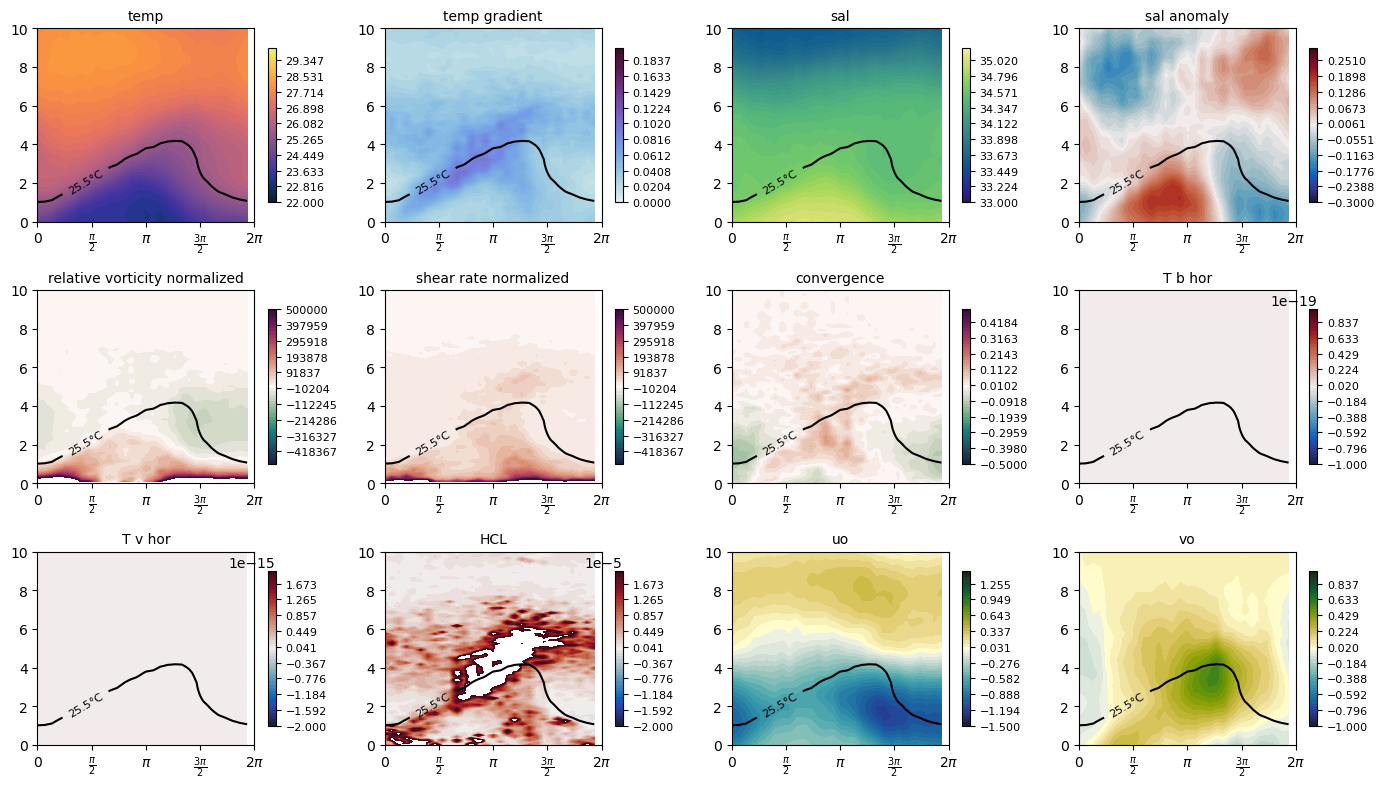

In [26]:
# composite 2d with isotherm
plot_simple_composite_hovmoller(
    n_bins, 
    composite_ds.mean(dim='longitude'), 
    latitude, 
    title=f"Hovmöller Diagram", 
    plot_params=plot_params, 
    isotherm_level=25.5 
)

## Read in Saildrone, TAO, and Seaglider Fronts

In [28]:
# Assign phase value to fronts
fronts_df = pd.read_csv('/Volumes/external/TIW/csv/Saildrone-fronts-QC.csv')
fronts_df["time"] = pd.to_datetime(fronts_df["time"])

fronts_df["phase"] = fronts_df.apply(
    lambda row: assign_phase(row, phase_ds, lon_range),
    axis=1
)


fronts_df["phase"] = np.mod(fronts_df["phase"], 2 * np.pi)

#fronts_df=fronts_df[fronts_df['lat']<9]

/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_86325/2663260311.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fronts_df["time"] = pd.to_datetime(fronts_df["time"])


In [29]:
fronts_df

,Mission,SD,idx,time,lat,lon,manual_QC,temp_diff,front_type,phase
0,2017,1006,112861,2017-11-19 09:00:00,7.995029,-125.015706,0,0.55,NaN,3.646009
1,2017,1006,113625,2017-11-19 21:45:00,7.963386,-125.093798,0,0.69,NaN,4.034050
2,2017,1006,115825,2017-11-21 10:24:00,7.398142,-125.055411,0,0.72,NaN,4.333000
3,2017,1006,138328,2017-12-07 01:28:00,1.801646,-125.127603,0,1.29,NaN,3.718676
4,2017,1006,140824,2017-12-08 19:03:00,1.095363,-125.489050,0,0.80,NaN,4.580602
...,...,...,...,...,...,...,...,...,...,...
88,2024,1090,1995,2024-10-30 07:14:00,9.867944,-124.890880,1,0.58,1.422076,NaN
89,2024,1090,2667,2024-10-30 18:26:00,9.583720,-124.949555,0,0.31,1.277772,NaN
90,2024,1090,16524,2024-11-09 09:22:00,6.039521,-125.406720,0,0.50,4.459516,NaN
91,2024,1090,32586,2024-11-20 13:05:00,1.615656,-135.627174,0,0.38,5.162704,NaN


/Users/katiekohlman/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


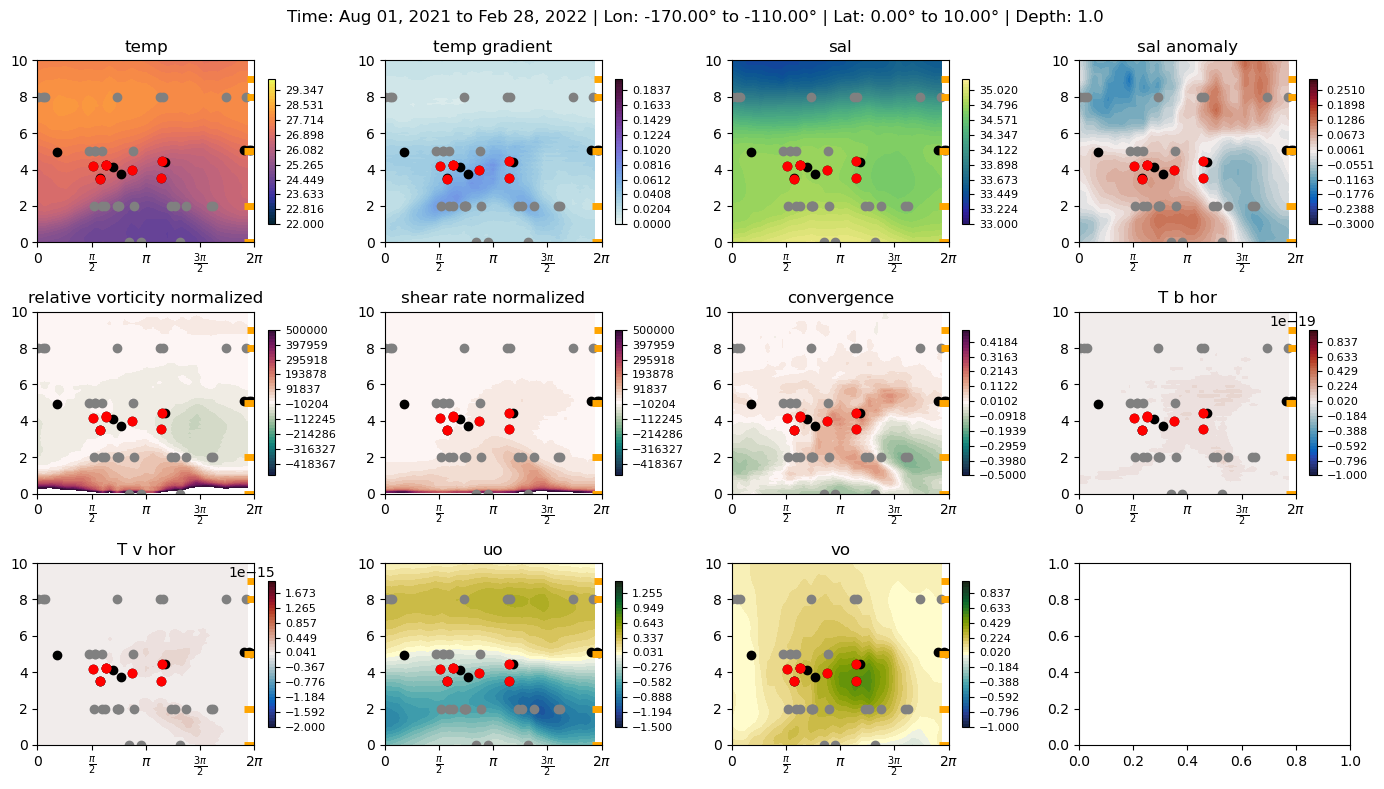

In [81]:
plot_large_hovemoller_composite_SD_TAO_SG(composite_ds.mean(dim='longitude'),phase_txt+'_repeated', n_bins,latitude,
                                   fronts_df,tao_fronts_df,seaglider_fronts_df,plot_params,glorys_ds)

In [ ]:
    `

#### old

In [ ]:
fronts_df_test = fronts_df[fronts_df['manual_QC']==0]
fronts_df_strong = fronts_df[(fronts_df['temp_diff']>=1)&(fronts_df['manual_QC']==0)]


fig, ax = plt.subplots(4, 1, figsize=(14, 8))

ax[0].hist(fronts_df_test['phase'],50,color='black',label='all fronts')
ax[0].hist(fronts_df_strong['phase'],50,color='red',label='strong fronts (>1C)')
ax[1].set_title('phase of saildrone-detected fronts')
ax[0].set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])
ax[0].legend()

ax[1].hist(fronts_df_test['lat'],50,color='black')
ax[1].hist(fronts_df_strong['lat'],50,color='red')
ax[1].set_title('latitude of saildrone-detected fronts')

ax[2].hist(fronts_df_test['lon'],50,color='black')
ax[2].hist(fronts_df_strong['lon'],50,color='red')
ax[2].set_xlim(-178,-110)
ax[2].set_title('longitude of saildrone-detected fronts')

ax[3].hist(fronts_df_test['temp_diff'],50,color='black')
ax[3].hist(fronts_df_strong['temp_diff'],50,color='red')
ax[3].set_title('strength (temp diff) of saildrone-detected fronts')

plt.tight_layout()
plt.show()

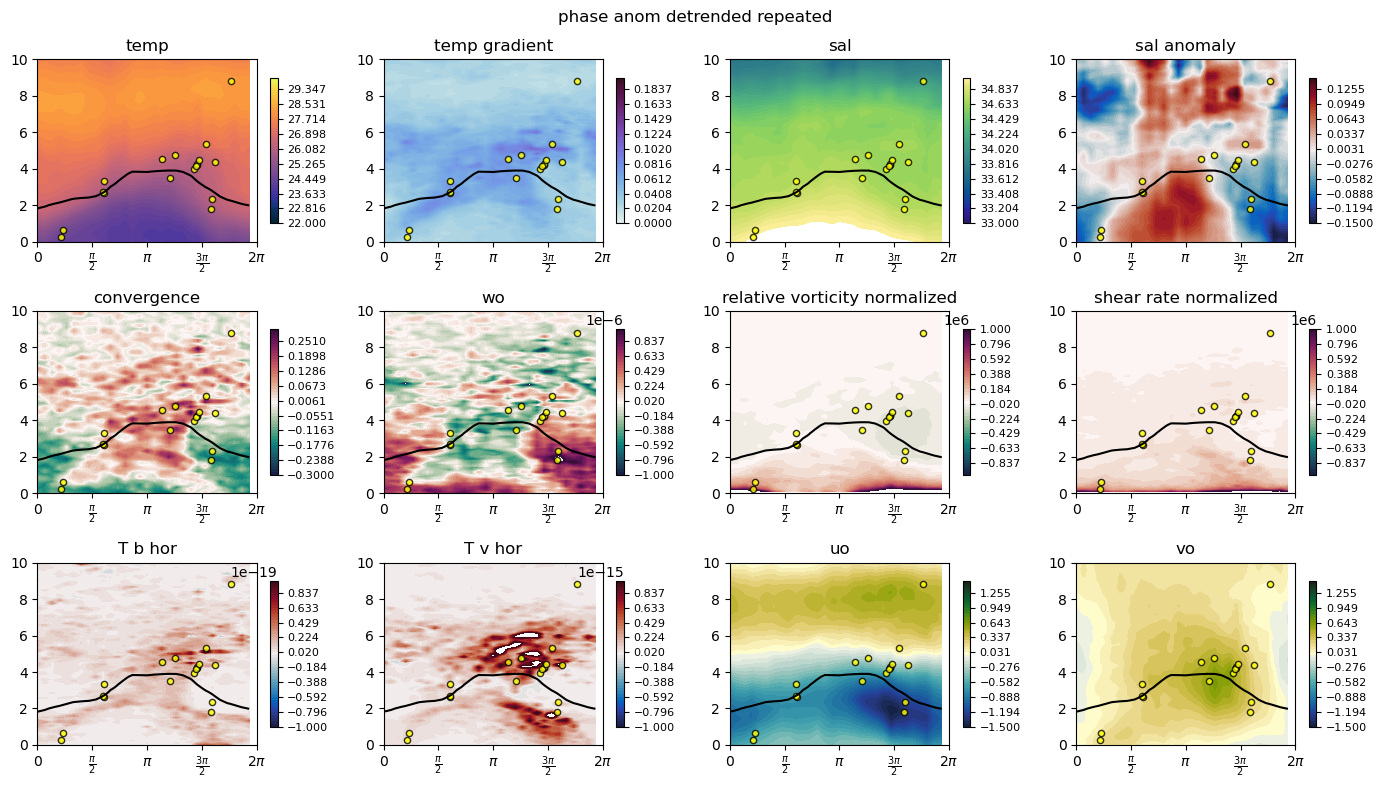

In [122]:
plot_large_hovemoller('phase_anom_detrended_repeated', 30)

In [107]:
len(fronts_df)

18

## code is very messy: 
* need to use other scripts to expand longitudinal extent.
* color fronts by mission
* add in other la nina seasons